In [43]:
# ------import------
import torch.nn as nn
import torch
import sys, os
sys.path.append(os.pardir)
from torchOptics import optics as tt
from torchOptics import models as tm
from torchOptics import quantum as qt
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm
import cv2

In [44]:
meta = {'wl':(638e-9, 515e-9, 450e-9), 'dx': (6.3e-6, 6.3e-6)}

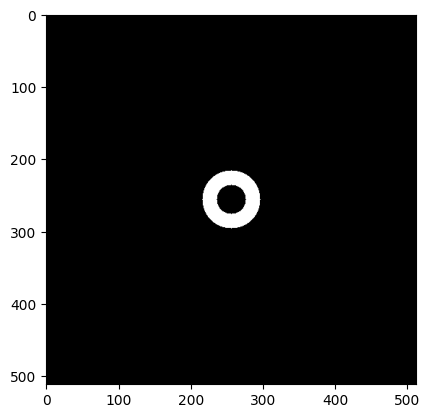

In [32]:
#timg
timg = np.zeros((512, 512))
cv2.circle(timg, (256, 256), 40, 255, thickness=-1)
cv2.circle(timg, (256,256), 20, 0, thickness=-1)
plt.imshow(timg, cmap='gray')
plt.show()

In [33]:
def GS_algorithm (img, max_iter) :
    #initial = SLM plane
    #final = lens focal plane
    h, w = (512, 512)
    initial_phase = torch.tensor(2*np.pi*np.random.rand(h, w)-np.pi).cuda()
    final_phase = torch.ones((h,w)).cuda()
    initial_amplitude = torch.sqrt(img).cuda()
    final_amplitude = torch.ones((h,w)).cuda()

    U_initial = tt.Tensor(initial_amplitude*torch.exp(1j*initial_phase), meta=meta)

    pbar = tqdm(range(max_iter))

    for i in pbar :
        
        U_final = tt.fft(U_initial)
        final_phase = torch.angle(U_final)
        U_final = final_amplitude*torch.exp(1j*final_phase)
        U_initial = tt.ifft(U_final)
        initial_phase = torch.angle(U_initial)
        U_initial = initial_amplitude*torch.exp(1j*initial_phase)

    Final_phase = final_phase
    return Final_phase

In [34]:
phase = GS_algorithm(torch.tensor(timg), 2000)
potential = tt.Tensor(tt.ifft(torch.exp(1j*phase)), meta=meta)

100%|██████████| 2000/2000 [00:00<00:00, 2196.82it/s]


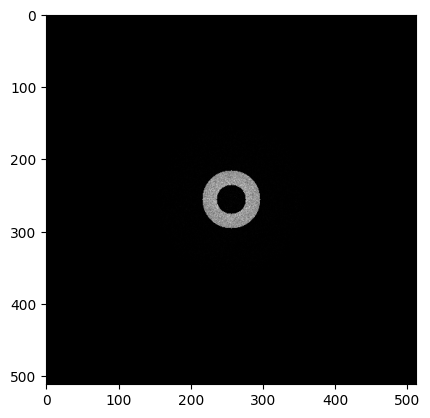

In [35]:
plt.imshow(np.abs(potential.cpu())**2, cmap='gray')
plt.show()

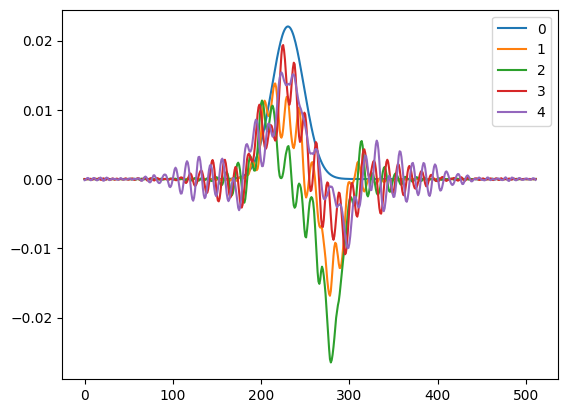

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


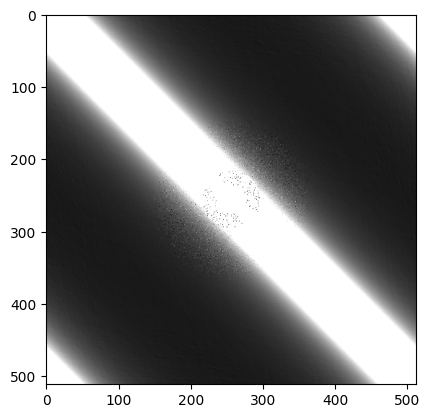

{'wl': (6.38e-07, 5.15e-07, 4.5e-07), 'dx': (6.3e-06, 6.3e-06)}


In [78]:
if __name__=='__main__':
    device = 'cpu'
    x = qt.position(-5, 5, 512).to(device)
    p = qt.momentum(x)
    H = p@p/2 + 50000*potential.to(device).to(dtype=torch.float64)**2

    L, V = torch.linalg.eigh(H)

    psi = qt.gaussian(x.diag(), x0=-0.5, w=0.5, A=1).to(dtype=torch.float64)
    psi = psi/psi.abs().sum()

    pred = qt.schrodinger(H, psi, torch.linspace(0, 0.1, 5))

    for idx,pp in enumerate(pred):
        plt.plot(pp.detach().cpu().real, label=idx)
    plt.legend()
    plt.show()
    print(H)

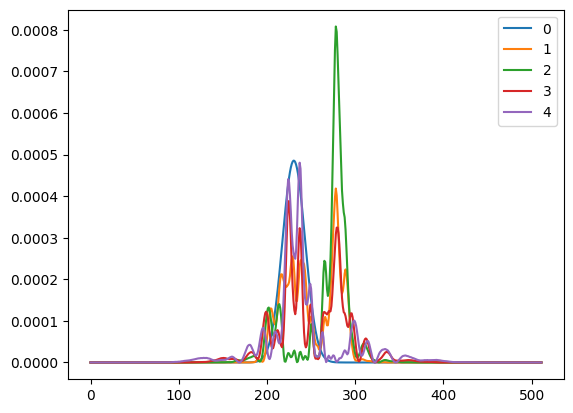

In [79]:
for idx,pp in enumerate(pred.abs()**2):
        plt.plot(pp.detach().cpu().real, label=idx)
plt.legend()
plt.show()

In [53]:
#timg2

size = 512  #배열 크기
sigma = 10  #표준편차
timg2 = np.zeros((size, size), dtype=np.float64)
amplitude = 1

#gaussian 추가
def add_gaussian(x1, y1, sigma, amplitude=amplitude):
    y, x = np.indices((size, size))
    x1 = float(x1)
    y1 = float(y1)
    gaussian = amplitude * np.exp(-((x-x1)**2+(y-y1)**2)/(2*sigma**2))
    return gaussian

centers = [(200, 200), (200, 350), (350, 350), (350, 200)]
for center in centers:
    timg2 += add_gaussian(center[0], center[1], sigma)

timg2 = tt.Tensor(timg2, meta=meta)

In [54]:
phase2= GS_algorithm(timg2, 2000)
potential2 = tt.Tensor(tt.ifft(torch.exp(1j*phase2)), meta=meta)

100%|██████████| 2000/2000 [00:00<00:00, 2219.50it/s]


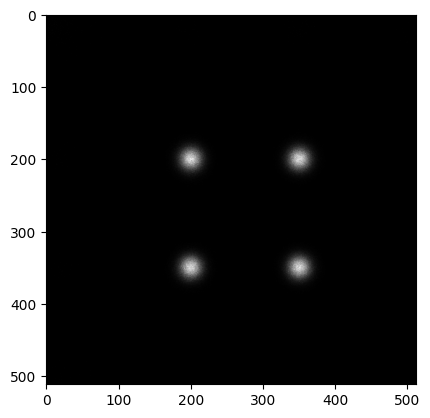

In [56]:
plt.imshow(np.abs(potential2.cpu())**2,cmap='gray')
plt.show()

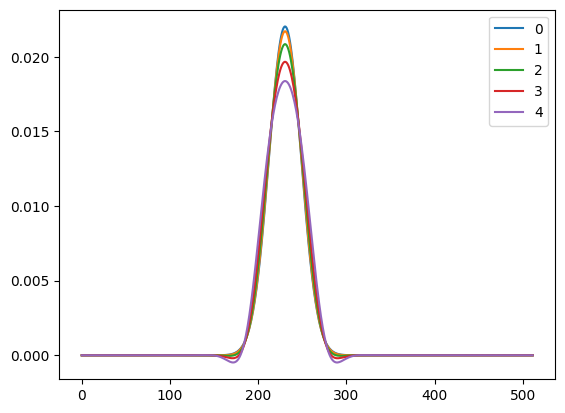

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


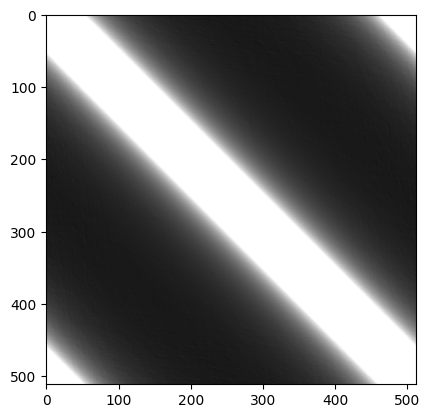

{'wl': (6.38e-07, 5.15e-07, 4.5e-07), 'dx': (6.3e-06, 6.3e-06)}


In [57]:
if __name__=='__main__':
    device = 'cpu'
    x = qt.position(-5, 5, 512)
    p = qt.momentum(x)
    H = p@p/2 + potential2.to(device).to(dtype=torch.float64).abs()**2 

    L, V = torch.linalg.eigh(H)

    psi = qt.gaussian(x.diag(), x0=-0.5, w=0.5, A=1).to(dtype=torch.float64)
    psi = psi/psi.abs().sum()

    pred2 = qt.schrodinger(H, psi, torch.linspace(0, 0.1, 5))

    for idx,pp in enumerate(pred2):
        plt.plot(pp.detach().cpu().real, label=idx)
    plt.legend()
    plt.show()
    print(H)

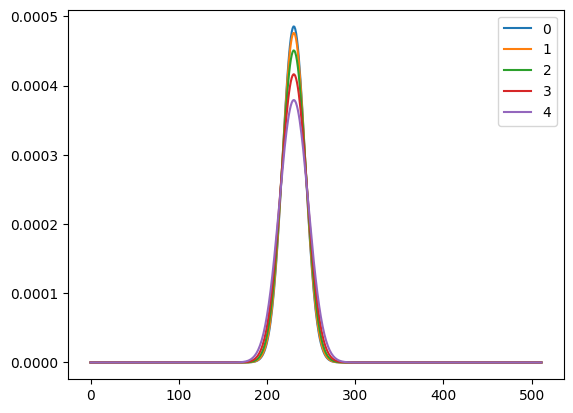

In [58]:
for idx,pp in enumerate(pred2.abs()**2):
        plt.plot(pp.detach().cpu().real, label=idx)
plt.legend()
plt.show()

In [59]:
np.argmax(pred2.cpu())

tensor(230)

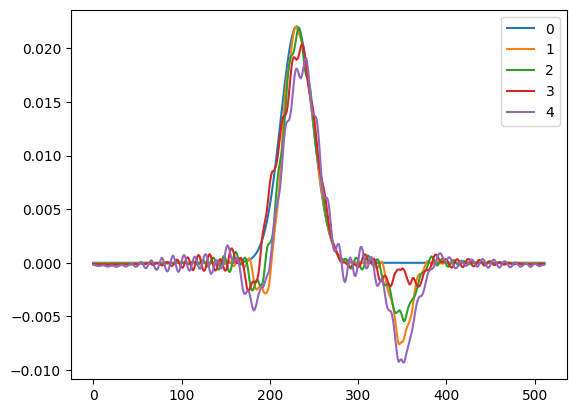

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


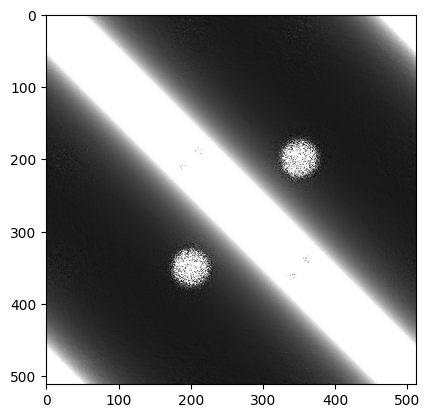

{'wl': (6.38e-07, 5.15e-07, 4.5e-07), 'dx': (6.3e-06, 6.3e-06)}


In [76]:
if __name__=='__main__':
    device = 'cpu'
    x = qt.position(-5, 5, 512)
    p = qt.momentum(x)
    H = p@p/2 + 50000*potential2.to(device).to(dtype=torch.float64).abs()**2 

    L, V = torch.linalg.eigh(H)

    psi = qt.gaussian(x.diag(), x0=-0.5, w=0.5, A=1).to(dtype=torch.float64)
    psi = psi/psi.abs().sum()

    pred2 = qt.schrodinger(H, psi, torch.linspace(0, 0.1, 5))

    for idx,pp in enumerate(pred2):
        plt.plot(pp.detach().cpu().real, label=idx)
    plt.legend()
    plt.show()
    print(H)

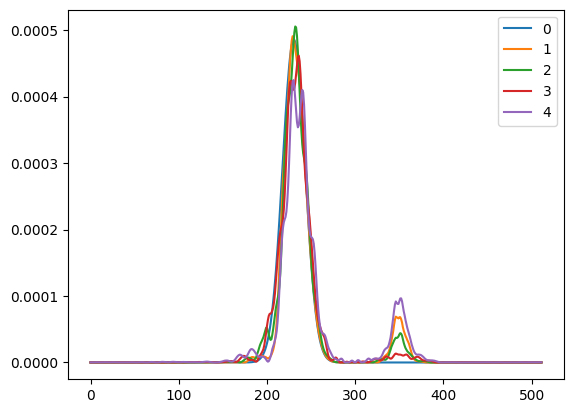

In [77]:
for idx,pp in enumerate(pred2.abs()**2):
        plt.plot(pp.detach().cpu().real, label=idx)
plt.legend()
plt.show()